In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import train_test_split

# Comparison of Bayesian Optimization Frameworks

According to the [Kaggle description](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption) the columns are defined as follows:

| Column     | Description                                                                                      |
|------------|--------------------------------------------------------------------------------------------------|
| school     | student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)                |
| sex        | student's sex (binary: 'F' - female or 'M' - male)                                            |
| age        | student's age (numeric: from 15 to 22)                                                        |
| address    | student's home address type (binary: 'U' - urban or 'R' - rural)                             |
| famsize    | family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)                   |
| Pstatus    | parent's cohabitation status (binary: 'T' - living together or 'A' - apart)                   |
| Medu       | mother's education (numeric: 0 - none, 1 - primary education (4th grade), ...)                |
| Fedu       | father's education (numeric: 0 - none, 1 - primary education (4th grade), ...)                |
| Mjob       | mother's job (nominal: 'teacher', 'health' care related, ...)                                  |
| Fjob       | father's job (nominal: 'teacher', 'health' care related, ...)                                  |
| reason     | reason to choose this school (nominal: close to 'home', school 'reputation', ...)               |
| guardian   | student's guardian (nominal: 'mother', 'father' or 'other')                                    |
| traveltime | home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., ...)                     |
| studytime  | weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, ...)                                |
| failures   | number of past class failures (numeric: n if 1<=n<3, else 4)                                   |
| schoolsup  | extra educational support (binary: yes or no)                                                   |
| famsup     | family educational support (binary: yes or no)                                                   |
| paid       | extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)           |
| activities | extra-curricular activities (binary: yes or no)                                                 |
| nursery    | attended nursery school (binary: yes or no)                                                     |
| higher     | wants to take higher education (binary: yes or no)                                              |
| internet   | Internet access at home (binary: yes or no)                                                     |
| romantic   | with a romantic relationship (binary: yes or no)                                                |
| famrel     | quality of family relationships (numeric: from 1 - very bad to 5 - excellent)                    |
| freetime   | free time after school (numeric: from 1 - very low to 5 - very high)                             |
| goout      | going out with friends (numeric: from 1 - very low to 5 - very high)                             |
| Dalc       | workday alcohol consumption (numeric: from 1 - very low to 5 - very high)                         |
| Walc       | weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)                         |
| health     | current health status (numeric: from 1 - very bad to 5 - very good)                               |
| absences   | number of school absences (numeric: from 0 to 93)                                               |
| G1         | first period grade (numeric: from 0 to 20)                                                       |
| G2         | second period grade (numeric: from 0 to 20)                                                      |
| G3         | final grade (numeric: from 0 to 20, output target)                                               |


In [3]:
RANDOM_SEED = 42

In [4]:
df = pd.read_csv('../datasets/student-alcohol-consumption.csv', index_col=[0])
print(df.shape)
df.head(5)

(395, 29)


,school,sex,age,famsize,Pstatus,Medu,Fedu,traveltime,failures,schoolsup,...,goout,Dalc,Walc,health,absences,G1,G2,G3,location,study_time
0,GP,F,18,GT3,A,4,4,2,0,yes,...,4,1,1,3,6,5,6,6,Urban,2 to 5 hours
1,GP,F,17,GT3,T,1,1,1,0,no,...,3,1,1,3,4,5,5,6,Urban,2 to 5 hours
2,GP,F,15,LE3,T,1,1,1,3,yes,...,2,2,3,3,10,7,8,10,Urban,2 to 5 hours
3,GP,F,15,GT3,T,4,2,1,0,no,...,2,1,1,5,2,15,14,15,Urban,5 to 10 hours
4,GP,F,16,GT3,T,3,3,1,0,no,...,2,1,2,5,4,6,10,10,Urban,2 to 5 hours


## Dataset Preparation

In [5]:
X = df.loc[:, ~df.columns.isin(['G1', 'G2', 'G3'])]
int_columns = X.select_dtypes(include=['int']).columns
X = X.loc[:, X.columns.isin(int_columns)]
y = df['G3']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_SEED)

print(f"""
Shapes
======
    train : {X_train.shape}
    val   : {X_val.shape}
    test  : {X_test.shape}
""")


Shapes
    train : (276, 12)
    val   : (59, 12)
    test  : (60, 12)



# Model Training & Hyperparameter Tuning 

The problem of predicting the final grade `G3` is a multi-class classification problem. For comparison purposes we are going to use different algorithms to train our model. The following sections will use different optimization packages and/or libraries to train the hyperparameters of the respective algorithms.


## Optuna w/o Cross Validation

In [46]:
N_TRIALS = 300

In [47]:
import optuna
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [48]:
accuracies_train, precisions_train, recalls_train, f1s_train = [], [], [], []
accuracies_val, precisions_val, recalls_val, f1s_val = [], [], [], []

def objective(trial):
    # Defining the hyperparameter search space.
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # Build the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED,
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred_train = pipeline.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    rec_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)    

    y_val_pred = pipeline.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    prec_val = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec_val = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1_val = f1_score(y_val, y_val_pred, average='macro', zero_division=0)    
    
    accuracies_train.append(acc_train)
    precisions_train.append(prec_train)
    recalls_train.append(rec_train)
    f1s_train.append(f1_train)

    accuracies_val.append(acc_val)
    precisions_val.append(prec_val)
    recalls_val.append(rec_val)
    f1s_val.append(f1_val)
    
    return prec_val


In [49]:
# Creating a study and running Optuna optimization.
study = optuna.create_study(study_name='my_optuna_study',
                            direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

# The searched optimal parameters.
best_params = study.best_params

# Create the pipeline with the searched optimal parameters.
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=RANDOM_SEED,
    ))
])

# Train the final model on the searched optimal parameters.
best_pipeline.fit(X_train, y_train)

# Train accuracy.
y_train_pred = best_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
train_rec = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

# Test accuracy.
y_test_pred = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"""
Optuna Results
==============
    Best hyperparameters: {best_params}

                {'Train':<10}{'Test':<10}
    Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
    Precision : {train_prec:<10.4f}{test_prec:<10.4f}
    Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
    F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
""")

[I 2023-08-07 16:55:43,755] A new study created in memory with name: my_optuna_study
[I 2023-08-07 16:55:44,045] Trial 0 finished with value: 0.01016949152542373 and parameters: {'n_estimators': 147, 'max_depth': 13, 'min_samples_split': 0.31373378203069074, 'min_samples_leaf': 0.38526090010392966}. Best is trial 0 with value: 0.01016949152542373.
[I 2023-08-07 16:55:44,161] Trial 1 finished with value: 0.01016949152542373 and parameters: {'n_estimators': 54, 'max_depth': 13, 'min_samples_split': 0.46531331479081595, 'min_samples_leaf': 0.45928004947195766}. Best is trial 0 with value: 0.01016949152542373.
[I 2023-08-07 16:55:44,344] Trial 2 finished with value: 0.01016949152542373 and parameters: {'n_estimators': 108, 'max_depth': 8, 'min_samples_split': 0.8451600745215379, 'min_samples_leaf': 0.4148445431149339}. Best is trial 0 with value: 0.01016949152542373.
[I 2023-08-07 16:55:44,555] Trial 3 finished with value: 0.01016949152542373 and parameters: {'n_estimators': 130, 'max_dept


Optuna Results
    Best hyperparameters: {'n_estimators': 207, 'max_depth': 3, 'min_samples_split': 0.4867855135963468, 'min_samples_leaf': 0.2778442524657851}

                Train     Test      
    Accuracy  : 0.2029    0.1000    
    Precision : 0.0441    0.0145    
    Recall    : 0.0834    0.0599    
    F1-Score  : 0.0506    0.0226    



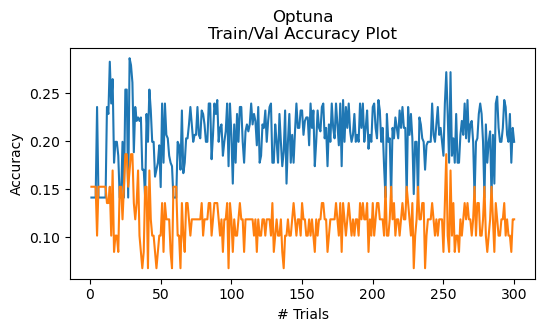

In [50]:
plt.figure(figsize=(6, 3))

plt.plot(np.arange(1, N_TRIALS+1, 1), accuracies_train, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), accuracies_val, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Accuracy");

plt.title("Optuna\nTrain/Val Accuracy Plot");
plt.show();

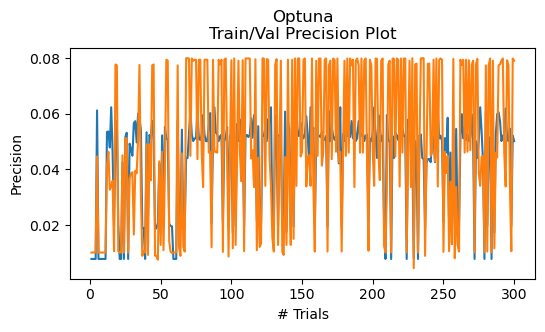

In [51]:
plt.figure(figsize=(6, 3))

plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_train, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_val, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Precision");

plt.title("Optuna\nTrain/Val Precision Plot");
plt.show();

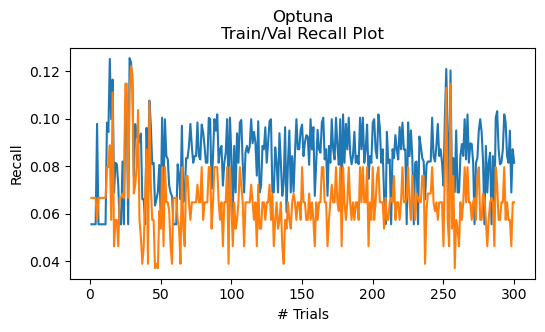

In [52]:
plt.figure(figsize=(6, 3))

plt.plot(np.arange(1, N_TRIALS+1, 1), recalls_train, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), recalls_val, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Recall");

plt.title("Optuna\nTrain/Val Recall Plot");
plt.show();

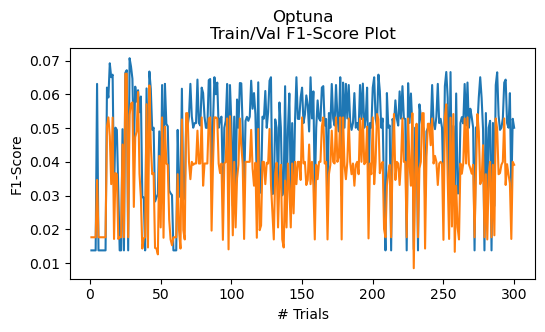

In [53]:
plt.figure(figsize=(6, 3))

plt.plot(np.arange(1, N_TRIALS+1, 1), f1s_train, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), f1s_val, color='C1');

plt.xlabel("# Trials");
plt.ylabel("F1-Score");

plt.title("Optuna\nTrain/Val F1-Score Plot");
plt.show();

## Optuna w/ Cross Validation

In [11]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [14]:
# Defining global variables.
RANDOM_SEED = 42
N_OUTER_FOLDS = 10
N_INNER_FOLDS = 5

# Lists to store accuracy scores and running times.
accuracy_scores = []
running_times = []


In [17]:
outer_kfold = KFold(n_splits=N_OUTER_FOLDS, 
                    shuffle=True, 
                    random_state=RANDOM_SEED)

for outer_train_indices, outer_test_indices in outer_kfold.split(X, y):
    X_outer_train, X_outer_test = X.loc[outer_train_indices], X.loc[outer_test_indices]
    y_outer_train, y_outer_test = y.loc[outer_train_indices], y.loc[outer_test_indices]

    print(X_outer_train.shape)
    
    inner_kfold = KFold(n_splits=N_INNER_FOLDS,
                        shuffle=True,
                        random_state=RANDOM_SEED)

    inner_scores = []
    for inner_train_indices, inner_val_indices in inner_kfold.split(X_outer_train, y_outer_train):
        X_inner_train, X_val = X_outer_train.loc[inner_train_indices], X_outer_train.loc[inner_val_indices]
        y_inner_train, y_val = y_outer_train.loc[inner_train_indices], y_outer_train.loc[inner_val_indices]

        # Creating a study and running Optuna optimization.
        study = optuna.create_study(study_name='my_optuna_study',
                                    direction='maximize')
        study.optimize(objective, n_trials=10)



(355, 12)
(355, 12)
(355, 12)
(355, 12)
(355, 12)
(356, 12)
(356, 12)
(356, 12)
(356, 12)
(356, 12)


In [7]:
def objective(trial):
    # Defining the hyperparameter search space.
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # Build the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED,
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    return acc


In [9]:
# Creating a study and running Optuna optimization.
study = optuna.create_study(study_name='my_optuna_study',
                            direction='maximize')
study.optimize(objective, n_trials=10)

# The searched optimal parameters.
best_params = study.best_params

# Create the pipeline with the searched optimal parameters.
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=RANDOM_SEED,
    ))
])

# Train the final model on the searched optimal parameters.
best_pipeline.fit(X_train, y_train)

# Train accuracy.
y_train_pred = best_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Test accuracy.
y_test_pred = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"""
Optuna Results
==============
    Best hyperparameters: {best_params}

    Accuracy
    --------
        Train: {train_acc:<0.4f} 
        Test : {test_acc:<0.4f}
""")

[I 2023-08-07 16:07:39,539] A new study created in memory with name: my_optuna_study


[I 2023-08-07 16:07:39,809] Trial 0 finished with value: 0.1864406779661017 and parameters: {'n_estimators': 158, 'max_depth': 10, 'min_samples_split': 0.578748660317236, 'min_samples_leaf': 0.12410371173766938}. Best is trial 0 with value: 0.1864406779661017.
[I 2023-08-07 16:07:40,091] Trial 1 finished with value: 0.1864406779661017 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.2272838601700773, 'min_samples_leaf': 0.16598005247459435}. Best is trial 0 with value: 0.1864406779661017.
[I 2023-08-07 16:07:40,428] Trial 2 finished with value: 0.15254237288135594 and parameters: {'n_estimators': 272, 'max_depth': 4, 'min_samples_split': 0.7177621603088598, 'min_samples_leaf': 0.1169548392375559}. Best is trial 0 with value: 0.1864406779661017.
[I 2023-08-07 16:07:40,827] Trial 3 finished with value: 0.15254237288135594 and parameters: {'n_estimators': 254, 'max_depth': 10, 'min_samples_split': 0.8429045510469035, 'min_samples_leaf': 0.16630922416702643}. Be


Optuna Results
    Best hyperparameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 0.42981193303194587, 'min_samples_leaf': 0.14947093381850293}

    Accuracy
    --------
        Train: 0.2609 
        Test : 0.1500

